In [2]:
from konlpy.tag import Komoran 
komoran = Komoran() 
print(komoran.morphs(u'졸린데 수업 끝내주세요'))
print(komoran.nouns(u'모기 물렸다'))

C:\Users\limaries30\.conda\envs\python3.6\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['졸리', 'ㄴ데', '수업', '끝내', '어', '주', '시', '어요']
['모기']


In [46]:
import os
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import json
import collections
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import copy

with open(r'C:\Users\limaries30\pythoncode\crawling_klue/44822_45041.json','r',encoding='UTF8') as f:
    data=pd.DataFrame(json.load(f))

In [4]:
example=data["LectureEval"][0][0]

In [5]:
example

'출첵은 거의 매일 하셨던 것 같구요. 중간에 우리나라 명소 사진 같은걸 찍어와서 글 쓰는 레포트가 있었는데 그거 하나 귀찮은거 빼고 나머지는 별 거 없어요. 수업은 책으로 진행하시는데 시험은 책에서 안나오고 그냥 주제에 대해 자기생각 쓰는거에요. 레포트가 별로였는데도 학점 꽤 주신것 같아요. B+ 받기는 쉽다고 생각해요.'

# Python regex

In [6]:
import re

In [7]:
help(re.sub)

Help on function sub in module re:

sub(pattern, repl, string, count=0, flags=0)
    Return the string obtained by replacing the leftmost
    non-overlapping occurrences of the pattern in string by the
    replacement repl.  repl can be either a string or a callable;
    if a string, backslash escapes in it are processed.  If it is
    a callable, it's passed the match object and must return
    a replacement string to be used.



In [8]:
re.sub(r'B+','A',example) #리스트 표현은 OR의 의미

'출첵은 거의 매일 하셨던 것 같구요. 중간에 우리나라 명소 사진 같은걸 찍어와서 글 쓰는 레포트가 있었는데 그거 하나 귀찮은거 빼고 나머지는 별 거 없어요. 수업은 책으로 진행하시는데 시험은 책에서 안나오고 그냥 주제에 대해 자기생각 쓰는거에요. 레포트가 별로였는데도 학점 꽤 주신것 같아요. A+ 받기는 쉽다고 생각해요.'

In [9]:
re.sub('\nB+','A+',example) #\n->메타문자인식

'출첵은 거의 매일 하셨던 것 같구요. 중간에 우리나라 명소 사진 같은걸 찍어와서 글 쓰는 레포트가 있었는데 그거 하나 귀찮은거 빼고 나머지는 별 거 없어요. 수업은 책으로 진행하시는데 시험은 책에서 안나오고 그냥 주제에 대해 자기생각 쓰는거에요. 레포트가 별로였는데도 학점 꽤 주신것 같아요. B+ 받기는 쉽다고 생각해요.'

# 분절하기

In [10]:
from nltk.tokenize import sent_tokenize #한국어는 왜 오류뜨나

example.strip() #양쪽공백지움

'출첵은 거의 매일 하셨던 것 같구요. 중간에 우리나라 명소 사진 같은걸 찍어와서 글 쓰는 레포트가 있었는데 그거 하나 귀찮은거 빼고 나머지는 별 거 없어요. 수업은 책으로 진행하시는데 시험은 책에서 안나오고 그냥 주제에 대해 자기생각 쓰는거에요. 레포트가 별로였는데도 학점 꽤 주신것 같아요. B+ 받기는 쉽다고 생각해요.'

## 문장분절

In [11]:
def sent_tok(sent):
    sent=re.sub('\n','.',sent)
    sent=list(filter(lambda x:x!='',list(map(lambda x:x.strip(),re.split(r"[.!?]",sent))))) #마지막에 split 때문에 ''딸려나옴
    
    return sent

In [12]:
sent_tok('안녕\n바보야')

['안녕', '바보야']

In [13]:
example_toks=sent_tok(example)
print(example_toks)

['출첵은 거의 매일 하셨던 것 같구요', '중간에 우리나라 명소 사진 같은걸 찍어와서 글 쓰는 레포트가 있었는데 그거 하나 귀찮은거 빼고 나머지는 별 거 없어요', '수업은 책으로 진행하시는데 시험은 책에서 안나오고 그냥 주제에 대해 자기생각 쓰는거에요', '레포트가 별로였는데도 학점 꽤 주신것 같아요', 'B+ 받기는 쉽다고 생각해요']


## 단어분절

In [14]:
list(map(komoran.nouns,example_toks))

[['것'],
 ['중간', '우리나라', '명소', '사진', '거', '글', '레포트', '거', '나머지', '거'],
 ['수업', '책', '진행', '시험', '책', '주제', '생각', '거'],
 ['레포트', '학점', '주신', '것'],
 ['생각']]

# TF-IDF
참고: https://donghwa-kim.github.io/TFIDF.html

## sklearn

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def pick(x):                 #filter 역할, 입력: pos tagging 된 sentence
    if x[1] in ['NNG','VA']:
        return x
    else:
        return None

In [17]:
a=komoran.pos(example)
a=list(map(lambda x:x[0],list(filter(pick,a))))
print(a)

['같', '중간', '명소', '사진', '같', '글', '레포트', '귀찮', '나머지', '없', '수업', '책', '진행', '시험', '책', '주제', '생각', '레포트', '주신', '같', '쉽', '생각']


In [18]:
vector = CountVectorizer()
vector.fit_transform(example_toks).toarray()  
print(vector.vocabulary_)  #dictionary
vector.fit_transform(a).toarray()  
print(vector.vocabulary_)  #dictionary

{'출첵은': 34, '거의': 3, '매일': 10, '하셨던': 36, '같구요': 0, '중간에': 29, '우리나라': 24, '명소': 11, '사진': 15, '같은걸': 2, '찍어와서': 31, '쓰는': 20, '레포트가': 9, '있었는데': 25, '그거': 5, '하나': 35, '귀찮은거': 4, '빼고': 14, '나머지는': 7, '없어요': 23, '수업은': 17, '책으로': 33, '진행하시는데': 30, '시험은': 19, '책에서': 32, '안나오고': 22, '그냥': 6, '주제에': 28, '대해': 8, '자기생각': 26, '쓰는거에요': 21, '별로였는데도': 13, '학점': 37, '주신것': 27, '같아요': 1, '받기는': 12, '쉽다고': 18, '생각해요': 16}
{'중간': 10, '명소': 3, '사진': 4, '레포트': 2, '귀찮': 0, '나머지': 1, '수업': 6, '진행': 11, '시험': 7, '주제': 9, '생각': 5, '주신': 8}


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidfv = TfidfVectorizer().fit(a)   #fit 과 transform의 차이
print(tfidfv.transform(a).toarray())
print(tfidfv.vocabulary_)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
{'중간': 10, '명소': 3, '사진': 4, '레포트': 2, '귀찮': 0, '나머지': 1, '수업': 6, '진행': 11, '시험': 7, '주제': 9, '생각': 5, '주신': 8}


In [21]:
def documentize(x):
    try:
    
        y=' '.join(x)
        a=komoran.pos(y.replace('\n',' '))
        a=' '.join(list(map(lambda x:x[0],list(filter(pick,a)))))
        
        return a
    except:
        return float('nan') #강의평없는경우

In [22]:
doc_word=data['LectureEval'].map(lambda x:documentize(x)) #시간좀걸림, 더좋은 방법 찾아봐야될듯
doc_word=pd.concat([data['className'],doc_word],axis=1).dropna().reset_index(drop=True)

In [75]:
tfidfv = TfidfVectorizer(max_df=0.9,min_df=0.2).fit(doc_word['LectureEval'].values)   #transform: 행렬변환, max_df: 0.9할 이상의 doc에서 나오는 단어 삭제
tfidf=tfidfv.transform(doc_word['LectureEval'].values).toarray()
vocab=tfidfv.vocabulary_

In [76]:
print(len(vocab))

94


In [77]:
lec_vec=dict(zip(doc_word['className'],tfidf))

In [78]:
def recommend(x,num,metric):   #사이킷런 knn 활용하기
    my_vec=lec_vec[x]
    
    new_dict=copy.deepcopy(lec_vec)  #깊복, 얕복 차이
    
    del new_dict[x]
    
    q=collections.deque(maxlen=num)
    q.append((x,1000))
    
    for k,v in new_dict.items():
        dist=metric(my_vec,v)
    
        if (q[0][1] > dist): #첫번째를 max로 유지
            q.append((k,dist))
            q=collections.deque(sorted(q,reverse=True,key=lambda x:x[1]),maxlen=num)
        
    return q

def l2_dis(x,y):
    return ((x-y)**2).sum()    

def cossim(x,y):
    return 1/(((x*y).sum()/(x**2).sum()**0.5/(y**2).sum()**0.5))
           

In [79]:
x='윈드서핑 OT,이론: 3/4, 3/11 8-9교시 사대신관B103호'
print("l2: ",recommend(x,5,l2_dis))
print('\n')
print("코사인유사도:" ,recommend(x,5,cossim))

l2:  deque([('소프트볼 OT: 3/3 2교시 사대신관B103호', 1.1166945080811679), ('골프 체육교육과 수강금지OT: 3/5 1-2교시 사대신관B103호', 1.0853661386732185), ('호신술 OT: 3/4 1,2교시 체육생활관 무도장', 1.0548252349369498), ('농구 체육교육과 수강금지 OT,이론: 3/6, 3/13, 3/20 3-4교시 사대신관223호', 1.0229348911659168), ('수상스키 OT,이론: 3/6, 3/13 8-9교시 사대신관327호, 3/20 8-9교시 사대신관327호', 1.0)], maxlen=5)


코사인유사도: deque([('소프트볼 OT: 3/6 4교시 사대신관327호', 2.514777216549497), ('소프트볼 OT: 3/3 2교시 사대신관B103호', 2.264222308473751), ('골프 체육교육과 수강금지OT: 3/5 1-2교시 사대신관B103호', 2.186667348067313), ('호신술 OT: 3/4 1,2교시 체육생활관 무도장', 2.116010788614934), ('농구 체육교육과 수강금지 OT,이론: 3/6, 3/13, 3/20 3-4교시 사대신관223호', 2.0469464950872824)], maxlen=5)


C:\Users\limaries30\.conda\envs\python3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\limaries30\.conda\envs\python3.6\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


# TSNE

In [83]:
tsne = TSNE(n_components=2, n_iter=10000, verbose=1,perplexity=30) #perplexity는 무엇

In [84]:
z=tsne.fit_transform(tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 215 samples in 0.001s...
[t-SNE] Computed neighbors for 215 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 215 / 215
[t-SNE] Mean sigma: 0.284629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.157150
[t-SNE] KL divergence after 1050 iterations: 0.819643


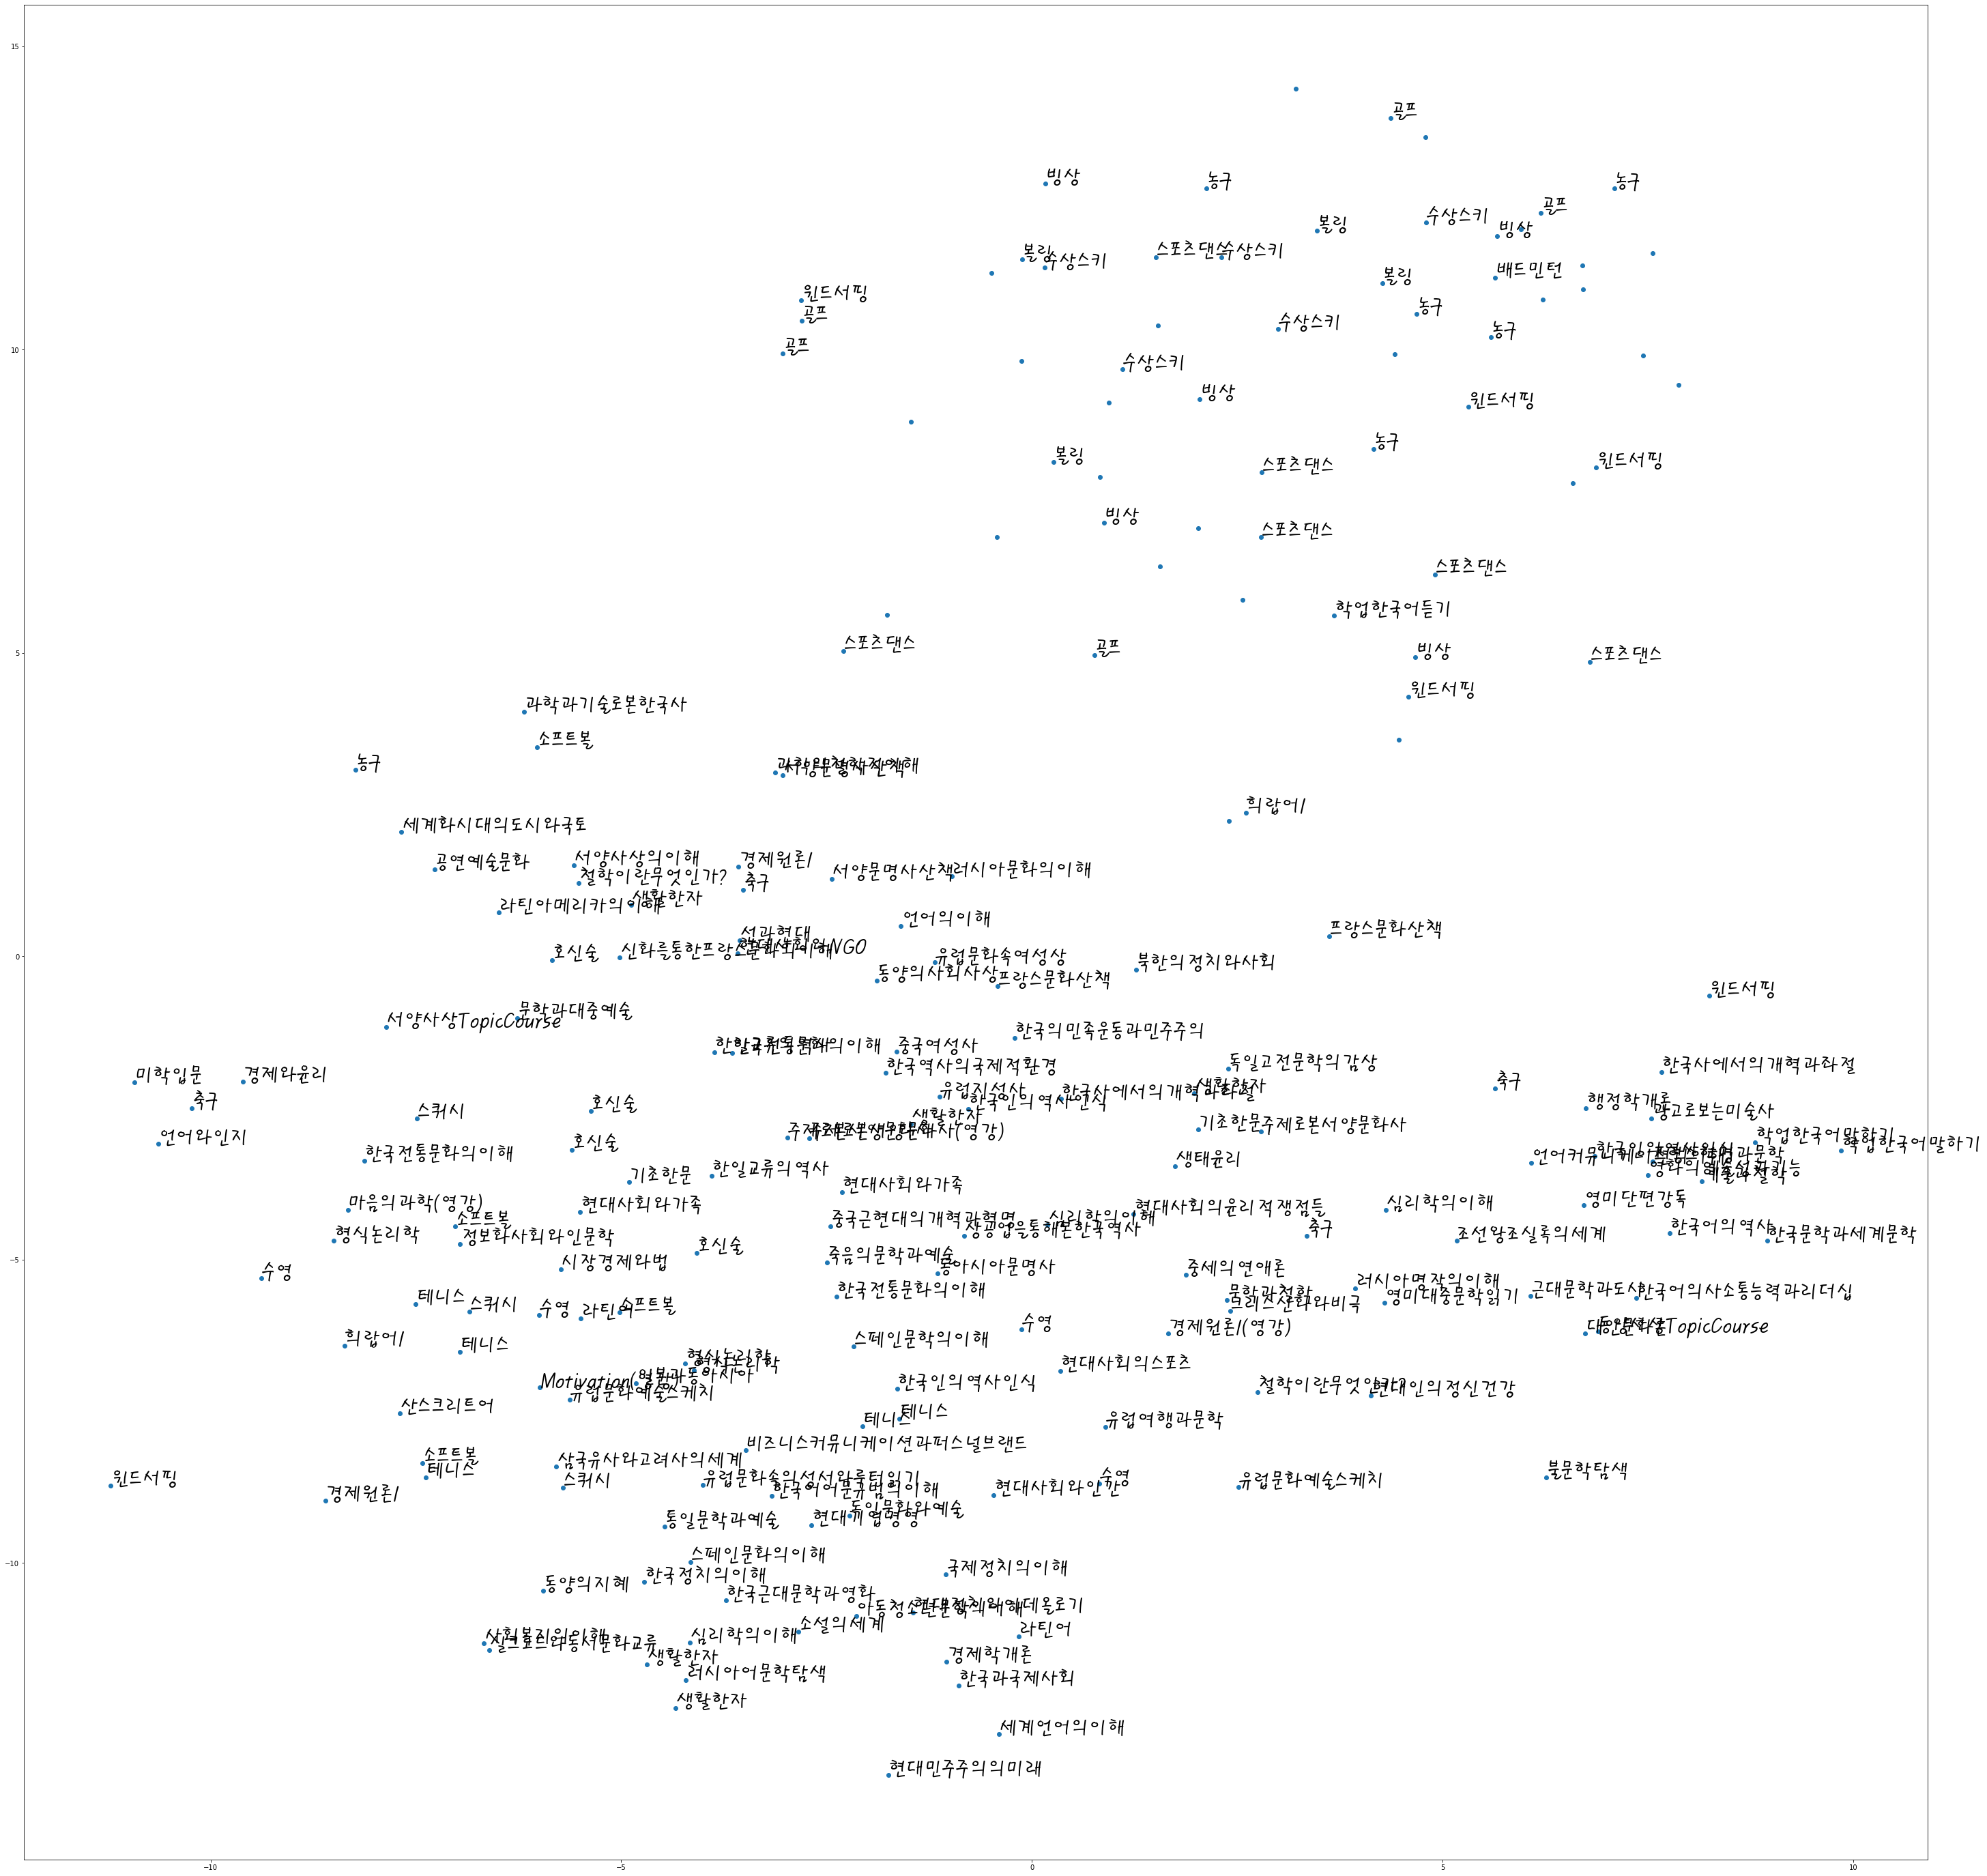

In [85]:
path='C:\Windows\Fonts\HMFMPYUN.ttf'
fontprop = fm.FontProperties(fname=path, size=30)
plt.figure(figsize=(50,50))
plt.scatter(z[:,0], z[:,1])

for i,k in enumerate(lec_vec.keys()):
    plt.annotate(s=k.split(' ')[0], xy=(z[i,0], z[i,1]),fontProperties =fontprop)
plt.show()